In [21]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Parameters
n = 30
C = 4
meanT = [30, 31, 32, 33, 34, 35]
meanM = 20
oneItemST = 3

# Factors
p = 0.5
K = 8

# CSV name
csv_name = "Continuity_New"

In [23]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "vector"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_8848\2527533774.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [24]:
number = "exponential(30s,_0)"
extracted_number = re.findall(r'\d+', number)[0]
print(extracted_number)

30


In [25]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: exponential(30s,_0)
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]

CSV_Vector = CSV[CSV["type"] == "vector"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:vector"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "TW": Exp_TW
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[1]] = re.findall(r'\d+', row["attrvalue"])[0]


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[1]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [26]:
# from statsmodels.graphics.gofplots import qqplot
# from pandas.plotting import lag_plot

# values = PI_df["TW"]["31"]["GS"].iloc[0]
# values = values.split(" ")
# values = [float(i) for i in values]
# values = pd.DataFrame(values)
# lag_plot(values)
# plt.show()
# subsample = values.sample(frac=0.3)
# subsample.sort_index(inplace=True)
# lag_plot(subsample)
# plt.show()
# sns.distplot(values, hist=False, rug=True)
# plt.show()

In [27]:
# Subsampling and Mean Computation
for t in meanT:
    for index, row in PI_df["TW"][str(t)].iterrows():
        values = row["GS"].split(" ")
        values = [float(v) for v in values]
        values = pd.DataFrame(values)
        subsample = values.sample(frac=0.3)
        PI_df["TW"][str(t)].loc[index, "GS"] = subsample.mean()[0]

In [28]:
PI_df["TW"]["30"]

,GS
0,123.149585
1,187.453981
2,146.465489
3,318.466582
4,217.150355
5,219.386375
6,191.577304
7,178.804497
8,182.959661
9,206.390698


In [29]:
pi = "TW"
P_LOG = {}
P_LOG[pi] = {}

for t in meanT:
    P_LOG[pi][str(t)] = pd.DataFrame(columns=["GS"])
    P_LOG[pi][str(t)]["GS"] = np.log(PI_df[pi][str(t)]["GS"].values.astype(np.float64).tolist())


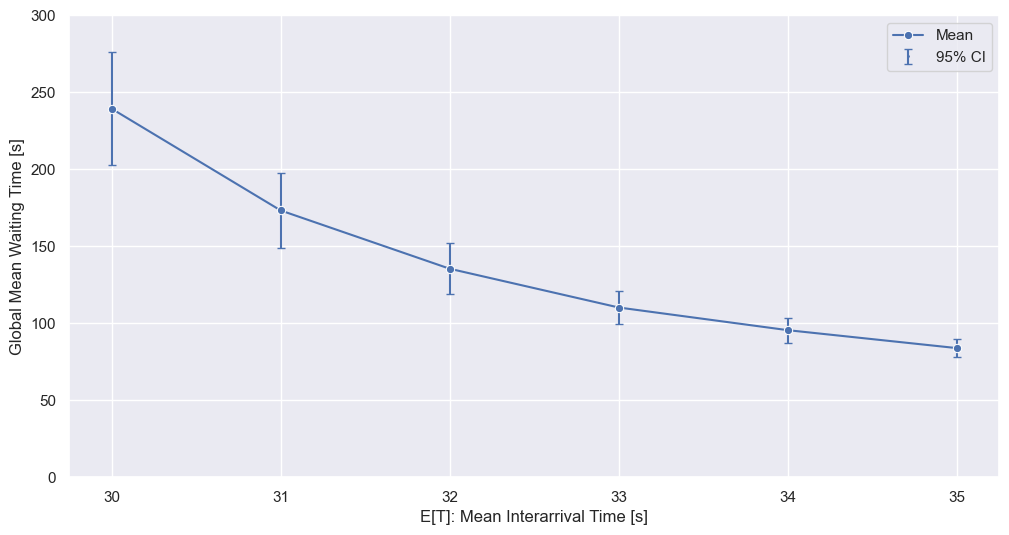

In [30]:
# (Normal)
# Continuity Test

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


y_V = []

# Confidence Interval Bounds
ci = []
ci_lb = []
ci_ub = []

for t in meanT:
    
    # We save in y_V the mean value for the current t
    y_V.append(PI_df[pi][str(t)]["GS"].mean())

    # We compute the confidence interval bounds
    ci.append(1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n)))
    ci_lb.append(PI_df[pi][str(t)]["GS"].mean() - (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))
    ci_ub.append(PI_df[pi][str(t)]["GS"].mean() + (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))

# We plot the confidence intervals
# plt.fill_between(meanT, ci_lb, ci_ub, alpha=0.1, label="95% CI")

plt.errorbar(x=meanT, y=y_V, fmt='o', yerr=ci, markersize=1, capsize=3, label="95% CI")

# We plot the line for the current p_
sns.lineplot(x=meanT, y=y_V, marker='o', label="Mean", color="b")


# Set the x-axis limits
# plt.xlim(0, 38)  
# Set the y-axis limits
plt.ylim(0, 300)  

# plt.title('Continuity Test with 95% CI [Focus]')
plt.xlabel('E[T]: Mean Interarrival Time [s]')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

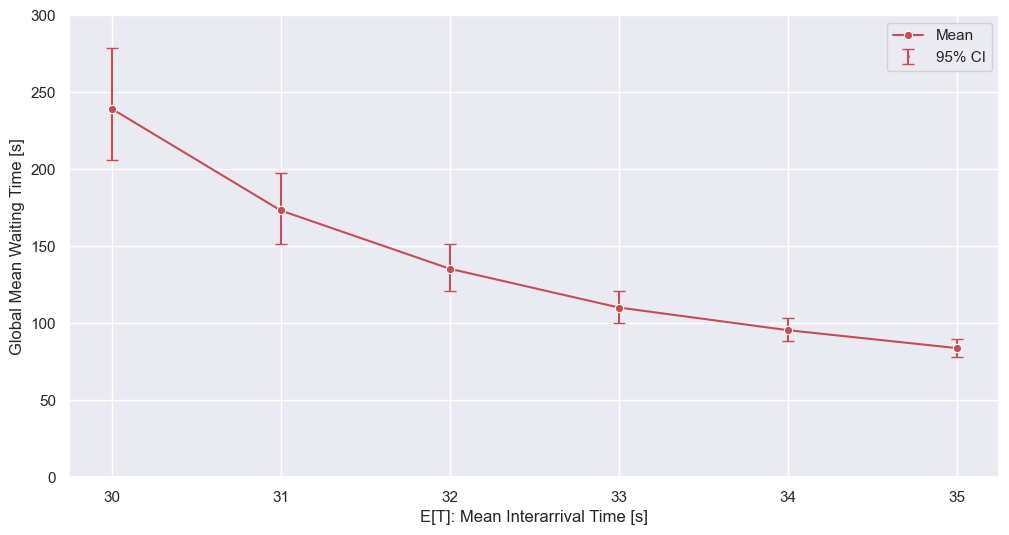

In [31]:
# (Cox Method)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


y_W = []

# Confidence Interval Bounds
ci_AA = []
ci_BB = []

ci_lb = []
ci_ub = []

for t in meanT:

    # We add one value to y_W
    y_W.append(PI_df[pi][str(t)]["GS"].mean())

    # We compute the confidence interval bounds
    
    # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
    ci_AA.append(PI_df[pi][str(t)]["GS"].mean() - np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))
    ci_BB.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))) - PI_df[pi][str(t)]["GS"].mean())

    ci_lb.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))
    ci_ub.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))


# We plot the confidence intervals
# plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

# We plot the error bars
plt.errorbar(x=meanT, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=1, capsize=4, label="95% CI", color="r")

# We plot the line for the current p_
sns.lineplot(x=meanT, y=y_W, marker='o', label="Mean", color="r")

# Set the x-axis limits
# plt.xlim(0, 38)  
# Set the y-axis limits
plt.ylim(0, 300)  

# plt.title('Continuity Test with 95% CI [Focus]')
plt.xlabel('E[T]: Mean Interarrival Time [s]')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()
